# Support Vector Regression

Haytham Mohamed - INFS890 - Spring 2020

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [120]:
is_factored_features = False

In [121]:
# 1- read data file
# 1- read processed file
file_dir = '../../data/processed-data/'

if is_factored_features:
    data_file = 'factored_dataset.csv'
else:
    data_file = 'normalized_dataset.csv'

data = pd.read_csv(file_dir + data_file)


In [122]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


## Linear Regression Model

In [123]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.2, random_state=365)

# for better convergence and result scale target to values between 0 - 1
maxltcy = targets.max()
y_train = y_train / maxltcy
y_test = y_test / maxltcy



In [124]:
def getPipeline(factored):
    # standardize the features
    scaler = StandardScaler()

    # using SelectFromModel metatransformer to select features
    clf = LassoCV()
    sfm = SelectFromModel(clf, threshold=0.01)

    # SVR
    svr = LinearSVR(C=0.1, random_state=365, verbose=1)
    
    if not factored:
        pline = Pipeline([
            ('scaler', scaler),
            ('feature_selection', sfm),
            ('regression', svr)
        ])
    else:
        pline = Pipeline([
            ('scaler', scaler),
            ('regression', svr)
        ])    
    
    return pline

In [125]:
pline = getPipeline(is_factored_features)
kfold = KFold(n_splits=10)
results = cross_val_score(pline, x_train , y_train, cv=kfold, scoring='neg_mean_squared_error')

print ("Done..!")

y_hat = pline.fit(x_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Done..!
[LibLinear]

In [126]:
y_hat = pline.predict(x_train)

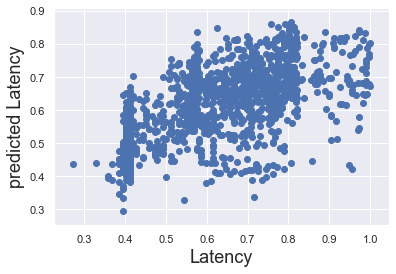

In [127]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

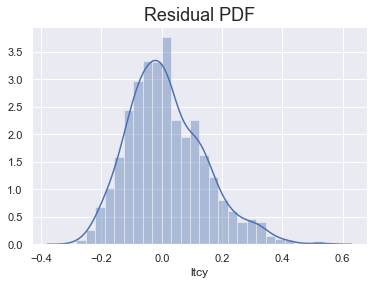

In [128]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [129]:
# R-Squared
pline.score(x_train, y_train)

0.34251594319550005

In [130]:
pline.named_steps.regression.intercept_

array([0.62226911])

In [131]:
pline.named_steps.regression.coef_

array([-0.00724602,  0.02010271, -0.06348373, -0.01774507,  0.17003731])

In [132]:
if not is_factored_features:
    selector = pline.named_steps.feature_selection
    selected_features = selector.transform(inputs)
    number_of_features = selected_features.shape[1]

    features = []
    for i in range(number_of_features):
        features.append('Feature_' + str(i))

    reg_summary = pd.DataFrame(features, columns=['features'])
    reg_summary['weights'] = pline.named_steps.regression.coef_
    reg_summary

In [133]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.10 (0.08) 0.00 0.53 MSE


### Testing

In [134]:
y_hat_test = pline.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

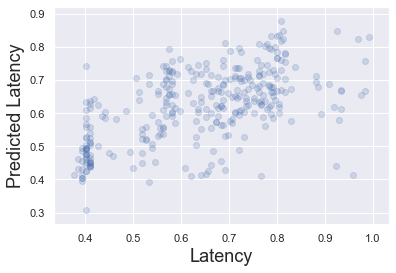

In [135]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [136]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.972,1.767
1,1.927,1.778
2,1.687,1.682
3,2.127,2.266
4,2.147,1.819


In [137]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.972,1.767,0.204,11.569
1,1.927,1.778,0.149,8.369
2,1.687,1.682,0.006,0.333
3,2.127,2.266,-0.139,6.139
4,2.147,1.819,0.328,18.014
...,...,...,...,...
312,2.294,2.700,-0.406,15.049
313,2.142,2.134,0.009,0.405
314,2.184,2.266,-0.082,3.621
315,1.873,2.238,-0.365,16.298


In [138]:
perf.describe()

,prediction,target,residual,difference%
count,317.000,317.000,317.000,317.000
mean,1.873,1.921,-0.048,9.654
std,0.205,0.292,0.245,7.455
min,1.361,1.457,-1.095,0.016
25%,1.717,1.704,-0.209,3.602
50%,1.882,1.940,-0.011,8.346
75%,2.019,2.143,0.117,13.522
max,2.405,2.700,0.608,41.977


In [139]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
156,2.02,2.02,0.00,0.02
7,1.48,1.48,0.00,0.08
87,1.99,1.99,0.00,0.10
249,2.04,2.04,0.00,0.11
202,1.99,1.99,-0.00,0.13
81,1.95,1.95,-0.00,0.21
77,1.74,1.75,-0.00,0.28
94,1.96,1.97,-0.01,0.28
2,1.69,1.68,0.01,0.33
252,1.69,1.69,-0.01,0.36


# Prediction Accuracy

In [140]:
# validation mean_absolute_percentage_error (MAPE)
test_error =  np.absolute(perf['residual'] / perf['target'])
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Absolute Percentate Error std of error (MAPE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))



Mean Absolute Percentate Error std of error (MAPE): [mean: 0.10 std: 0.07 max: 0.42 min: 0.00]


In [141]:
# validation mean_squared_error  (MSE)
test_error =  np.power(perf['residual'] , 2)
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Squared Error (MSE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))



Mean Squared Error (MSE): [mean: 0.06 std: 0.12 max: 1.20 min: 0.00]


R2 is a statistic that will give some information about the goodness of fit of a model. In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

In [142]:
# R-Squared 
# = 1 -  ( sum of squared residual  / sum of squared variance )
# sum of variance squared = sum (( y - y-mean ) ** 2)
# sum of residual squared = sum (( y-hat - y-mean ) ** 2)
# where y is the observed target, y-mean is the mean of observed target, y-hat is a predicted value

y_mean = np.mean(targets)
sum_squared_residual = np.sum(np.power(perf['residual'] , 2))
sum_squared_variance = np.sum(np.power(targets - y_mean , 2))

R_squared = 1 - ( sum_squared_residual / sum_squared_variance )

R_squared


0.657909863120768